Importing the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extracting the MFCC Features from the Audio Files

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import soundfile as sf
import librosa
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Set the path to the folder containing the audio files
data_folder = 'Add the path of the dataset here where the audio files are stored'

# Set the desired number of MFCC coefficients and maximum sequence length
num_coefficients = 13
max_sequence_length = 1000

# Create empty lists to store the MFCC features and speaker labels
mfcc_features = []
speaker_labels = []

# Iterate through the audio files in the folder
for filename in os.listdir(data_folder):
    # The Files are in .flac format
    if filename.endswith('.flac'):
        # Extract the speaker ID from the filename
        # The filename format is: {speakerID}-{index}.flac
        speaker_id = filename.split('-')[0]

        # Load the audio file
        audio, sr = sf.read(os.path.join(data_folder, filename))

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_coefficients)

        # Pad or truncate the MFCC features to the maximum sequence length
        if mfcc.shape[1] < max_sequence_length:
            pad_width = max_sequence_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)))
        else:
            mfcc = mfcc[:, :max_sequence_length]

        # Append the MFCC features and speaker label to the lists
        mfcc_features.append(mfcc)
        speaker_labels.append(speaker_id)

# Convert the lists to numpy arrays
mfcc_features = np.array(mfcc_features)
speaker_labels = np.array(speaker_labels)

# Split the data into training and testing sets
trainMFCC, testMFCC, trainSpeakerIDs, testSpeakerIDs = train_test_split(
    mfcc_features, speaker_labels, test_size=0.2, random_state=42)

# Reshape the input data
trainMFCC = trainMFCC[..., np.newaxis]
testMFCC = testMFCC[..., np.newaxis]

# Convert speaker IDs to numerical labels
unique_speakers = np.unique(speaker_labels)
num_speakers = len(unique_speakers)
label_to_id = {label: i for i, label in enumerate(unique_speakers)}
trainLabels = np.array([label_to_id[label] for label in trainSpeakerIDs])
testLabels = np.array([label_to_id[label] for label in testSpeakerIDs])

Applying Scaling, SVD and Random Forest Classifier

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
scaler = StandardScaler()
trainMFCC_flat = trainMFCC.reshape(trainMFCC.shape[0], -1)
testMFCC_flat = testMFCC.reshape(testMFCC.shape[0], -1)
trainMFCC_flat = scaler.fit_transform(trainMFCC_flat)
testMFCC_flat = scaler.transform(testMFCC_flat)

# Apply dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=50)  # Adjust the number of components
trainMFCC_reduced = svd.fit_transform(trainMFCC_flat)
testMFCC_reduced = svd.transform(testMFCC_flat)

# Create the Random Forest model
model = RandomForestClassifier(n_estimators=100)  # Adjust the number of estimators

# Train the model
model.fit(trainMFCC_reduced, trainLabels)

# Test the model
predictions = model.predict(testMFCC_reduced)

# Calculate accuracy
accuracy = accuracy_score(testLabels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9517102615694165


Classfication Report and Accuarcy Score

Confusion Matrix:


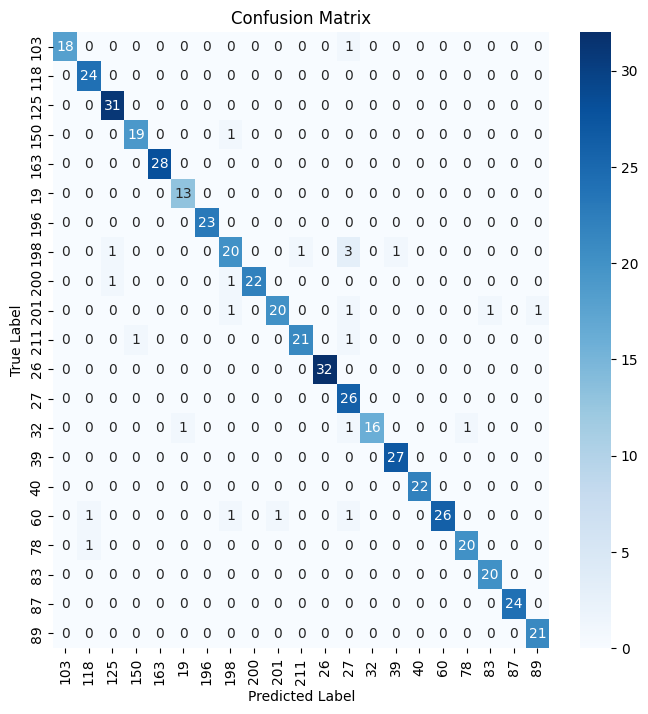


Classification Report:
              precision    recall  f1-score   support

         103       1.00      0.95      0.97        19
         118       0.92      1.00      0.96        24
         125       0.94      1.00      0.97        31
         150       0.95      0.95      0.95        20
         163       1.00      1.00      1.00        28
          19       0.93      1.00      0.96        13
         196       1.00      1.00      1.00        23
         198       0.83      0.77      0.80        26
         200       1.00      0.92      0.96        24
         201       0.95      0.83      0.89        24
         211       0.95      0.91      0.93        23
          26       1.00      1.00      1.00        32
          27       0.76      1.00      0.87        26
          32       1.00      0.84      0.91        19
          39       0.96      1.00      0.98        27
          40       1.00      1.00      1.00        22
          60       1.00      0.87      0.93        30
   

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(testLabels, predictions)

# Calculate classification report
class_names = unique_speakers
report = classification_report(testLabels, predictions, target_names=class_names)

print("Confusion Matrix:")
# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(report)

Applying Sclaing, SVD and Decision Tree Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
scaler = StandardScaler()
trainMFCC_flat = trainMFCC.reshape(trainMFCC.shape[0], -1)
testMFCC_flat = testMFCC.reshape(testMFCC.shape[0], -1)
trainMFCC_flat = scaler.fit_transform(trainMFCC_flat)
testMFCC_flat = scaler.transform(testMFCC_flat)

# Apply dimensionality reduction using TruncatedSVD

# Apply dimensionality reduction using SVD
svd = TruncatedSVD(n_components=100, random_state=42)

# Fit SVD on the normalized training data and transform it
trainMFCC_svd = svd.fit_transform(trainMFCC_flat)

# Transform the normalized testing data using the trained SVD
testMFCC_svd = svd.transform(testMFCC_flat)


model = DecisionTreeClassifier(criterion = 'gini',min_samples_split=2)
model.fit(trainMFCC_svd, trainLabels)

# Test the model
predictions = model.predict(testMFCC_svd)

# Calculate accuracy
accuracy = accuracy_score(testLabels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7847082494969819


Applying PCA and Decision Tree Classifier

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)  # Set the desired number of components
trainMFCC_flat = trainMFCC.reshape(trainMFCC.shape[0], -1)
trainMFCC_reduced = pca.fit_transform(trainMFCC_flat)
testMFCC_flat = testMFCC.reshape(testMFCC.shape[0], -1)
testMFCC_reduced = pca.transform(testMFCC_flat)

# Create the decision tree model
model = DecisionTreeClassifier(criterion='log_loss', min_samples_split=3)

# Train the model
model.fit(trainMFCC_reduced, trainLabels)

# Test the model
predictions = model.predict(testMFCC_reduced)

# Calculate accuracy
accuracy = accuracy_score(testLabels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.24346076458752516


Decision Tree Classifier With Different Parameters

In [ ]:
from sklearn.decomposition import TruncatedSVD
scaler = StandardScaler()
trainMFCC_normalized = scaler.fit_transform(trainMFCC.reshape(trainMFCC.shape[0], -1))
testMFCC_normalized = scaler.transform(testMFCC.reshape(testMFCC.shape[0], -1))

# Apply dimensionality reduction using SVD
svd = TruncatedSVD(n_components=50, random_state=42)

# Fit SVD on the normalized training data and transform it
trainMFCC_svd = svd.fit_transform(trainMFCC_normalized)

# Transform the normalized testing data using the trained SVD
testMFCC_svd = svd.transform(testMFCC_normalized)

# Create the decision tree model
model = DecisionTreeClassifier(criterion='log_loss', min_samples_split=3)

# Train the model
model.fit(trainMFCC_svd, trainLabels)

# Test the model
predictions = model.predict(testMFCC_svd)

# Calculate accuracy
accuracy = accuracy_score(testLabels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7967806841046278


Decision Tree Classifier with Hyperparameter Tuning 

In [ ]:
c = ['gini', 'entropy','log_loss']
d = ["auto", "sqrt", "log2"]

for s_c in c:
    for i in range(2,5):

        # Create the decision tree model
        model = DecisionTreeClassifier(criterion = s_c,min_samples_split=i)

        # Flatten the training data
        trainMFCC_flat = trainMFCC.reshape(trainMFCC.shape[0], -1)

        # Train the model
        model.fit(trainMFCC_flat, trainLabels)

        # Flatten the testing data
        testMFCC_flat = testMFCC.reshape(testMFCC.shape[0], -1)

        # Test the model
        predictions = model.predict(testMFCC_flat)

        # Calculate accuracy
        accuracy = accuracy_score(testLabels, predictions)
        print(i,s_c)
        print("Accuracy:", accuracy)

2 gini
Accuracy: 0.7079646017699115
3 gini
Accuracy: 0.7345132743362832
4 gini
Accuracy: 0.7256637168141593
2 entropy
Accuracy: 0.7876106194690266
3 entropy
Accuracy: 0.831858407079646
4 entropy
Accuracy: 0.7964601769911505
2 log_loss
Accuracy: 0.831858407079646
3 log_loss
Accuracy: 0.8053097345132744
4 log_loss
Accuracy: 0.7876106194690266
2 gini
Accuracy: 0.7433628318584071
3 gini
Accuracy: 0.7345132743362832
4 gini
Accuracy: 0.7345132743362832
2 entropy
Accuracy: 0.8407079646017699
3 entropy
Accuracy: 0.8141592920353983
4 entropy
Accuracy: 0.7964601769911505
2 log_loss
Accuracy: 0.8141592920353983
3 log_loss
Accuracy: 0.7964601769911505
4 log_loss
Accuracy: 0.7699115044247787
